# Hello PyTorch Convolutional Neural Networks

This notebook provides a real use case of CNNs for solving the oceanograhpy problem of automatic detection of the Loop Current in the Gulf of Mexico



In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import time as t
import cv2
import xarray as xr

device = "cuda" if torch.cuda.is_available() else "cpu"

## Read data

In [2]:
# Read example
x = np.load('./imgs/aviso/1993-2013.npy')
y = np.load('./imgs/aviso/1993-2013-mask.npy')
num_examples = 1000
x = x[:num_examples,::-1,:]
y = y[:num_examples,::-1,:]
tot_ex = x.shape[0]

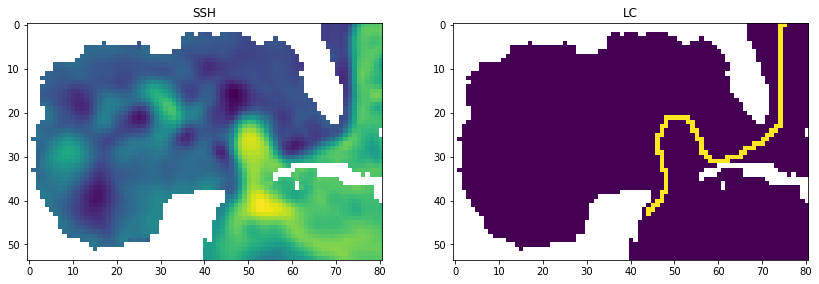

In [3]:
# Plot
fig, axs = plt.subplots(1,2, figsize=(14,7))
print(x.shape)

for i in range(10):
    i = np.random.randint(0,tot_ex,1)[0]
    axs[0].cla()
    axs[1].cla()
    display.clear_output(wait =True)
    axs[0].imshow(x[i,:,:])
    axs[0].set_title("SSH")
    axs[1].imshow(y[i,:,:])
    axs[1].set_title("LC")
    plt.draw()
    t.sleep(0.2)
    display.display(plt.gcf())
display.clear_output(wait =True)

1. Generate some synthetic data

Total number of parameters:  4905
Original shape (1000, 54, 81)
Input shape torch.Size([1000, 1, 54, 81])


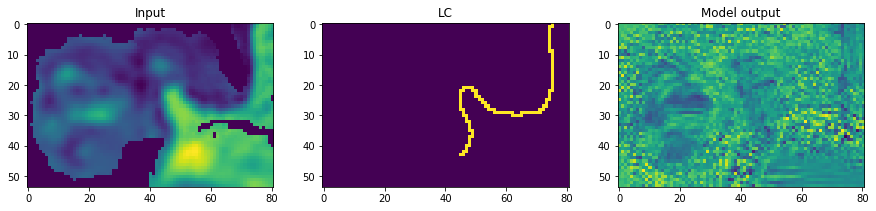

In [4]:
# Models are created by classes that inherit from Module
class SingleCNNModel(nn.Module):
    # On the init function we define our model
    def __init__(self):
        super().__init__() # Constructor of parent class
        self.conv1 =  nn.Conv2d(1, 1, 3, padding=1, padding_mode='reflect')
        self.relu = nn.ReLU()
    
    # On the forward function we indicate how to make one 'pass' of the model
    def forward(self, x):
        l1 = self.conv1(x)
        return l1
    
class MultipleLayersCNNModel(nn.Module):
    # On the init function we define our model
    def __init__(self):
        super().__init__() # Constructor of parent class
        self.n_cnn_layers = 8
        self.hidden_filters = 8
        self.convin =  nn.Conv2d(1, self.hidden_filters, 3, padding=1, padding_mode='reflect') 
        self.convlayers=  nn.ModuleList([nn.Conv2d(self.hidden_filters, self.hidden_filters, 3, padding=1, padding_mode='reflect') for x in range(self.n_cnn_layers)])
        self.bn = nn.ModuleList([nn.BatchNorm2d(self.hidden_filters) for x in range(self.n_cnn_layers+1)])
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()
        self.convout =  nn.Conv2d(self.hidden_filters, 1, 1)
    
    # On the forward function we indicate how to make one 'pass' of the model
    def forward(self, x):
        l1 = self.bn[0](nn.functional.relu(self.convin(x)))
        for i in range(self.n_cnn_layers):
            l1 = self.bn[i+1](nn.functional.relu(self.convlayers[i](l1)))  # With batch normalization
        l1 = self.sig(self.convout(l1))
        # l1 = self.convout(l1)
        return l1
    
# ex_model = SingleCNNModel().to(device)
ex_model = MultipleLayersCNNModel().to(device)
# print(list(ex_model.named_parameters()))
print("Total number of parameters: ", sum(p.numel() for p in ex_model.parameters() if p.requires_grad))

np.nan_to_num(x,0)
np.nan_to_num(y,0)
# Reshape to the proper input of the network
X_torch = torch.reshape(torch.tensor(x.copy()), (x.shape[0], 1, x.shape[1], x.shape[2])).to(device, dtype=torch.float)
Y_torch = torch.reshape(torch.tensor(y.copy()), (y.shape[0], 1, y.shape[1], y.shape[2])).to(device, dtype=torch.float)
print("Original shape", x.shape)
print("Input shape", X_torch.shape)

model_y = ex_model(X_torch).cpu().detach().numpy()
#-------------- Just for plotting --------------
fig, ax = plt.subplots(1,3, figsize=(15,5))
def plotCurrentModel(x, y, model, ax):
    # Torch receives inputs with shape [Examples, input_size]
    ax[0].imshow(x)
    ax[0].set_title('Input')
    ax[1].imshow(y)
    ax[1].set_title('LC')
    im = ax[2].imshow(model)
    ax[2].set_title('Model output')
    
ex = 0
plotCurrentModel(x[ex,:,:], y[ex,:,:], model_y[ex,0,:,:], ax)

3.Optimize the parameters of the model using backpropagation 

In [5]:
loss_mse = nn.MSELoss() # Define loss function
optimizer = torch.optim.SGD(ex_model.parameters(), lr=1e-3) # Define optimization algorithm

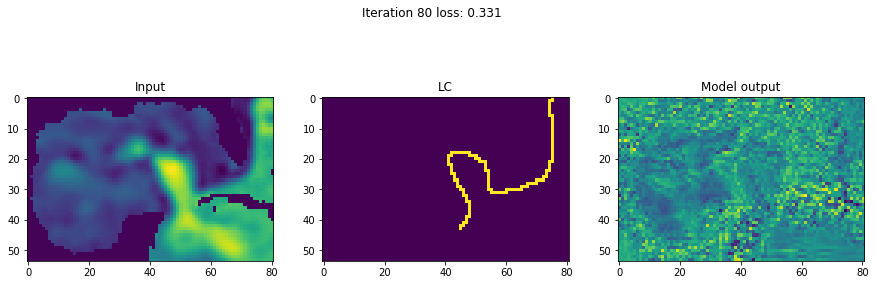

In [6]:
# Optimize the parameters several times

fig, ax = plt.subplots(1,3, figsize=(15,5))
ex_model.train()
for i in range(81):
    pred = ex_model(X_torch)
    loss = loss_mse(pred, Y_torch)
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # ---------- Just for plotting ---------
    if i % 20 == 0: 
        title = f"Iteration number {i} loss: {loss:0.3f}"
        print(title)
        display.clear_output(wait =True)
        ex = np.random.randint(0,1000,1)[0]
        model_y = ex_model(X_torch).cpu().detach().numpy()
        plotCurrentModel(x[ex,:,:], y[ex,:,:], model_y[ex,0,:,:], ax)
        plt.suptitle(f'Iteration {i} loss: {loss:.3f}')
        plt.draw()
        t.sleep(0.1)
        display.display(plt.gcf())
    
print("Done!")
print(list(ex_model.named_parameters()))
display.clear_output(wait =True)